In [28]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification
import csv
import warnings 
warnings.filterwarnings('ignore')

# Data Preparation


Prepare the data to be used with kNN

In [2]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots)  

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[1].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7404:4:404:,grid9_1bh-7_2019-02-13_20:02_,175,138.560571,7745.631023,88.009267,2,69.1,587.0,0.125,8,Black Hole
1,aaaa::212:7405:5:505:,grid9_1bh-7_2019-02-13_20:02_,200,163.620000,5208.769447,72.171805,3,101.0,902.0,0.000,7,Black Hole
2,aaaa::212:7409:9:909:,grid9_1bh-7_2019-02-13_20:02_,196,190.556122,8797.714783,93.796134,3,103.0,723.0,0.020,12,Black Hole
3,aaaa::212:7402:2:202:,grid9_1bh-7_2019-02-13_20:02_,182,100.343956,3199.643140,56.565388,2,56.3,439.0,0.090,11,Black Hole
4,aaaa::212:7408:8:808:,grid9_1bh-7_2019-02-13_20:02_,133,250.315789,3884.505582,62.325802,4,175.0,618.0,0.335,8,Black Hole


Stats for single network

In [3]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 9)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 9, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 9, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 9, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9
0,grid9_1bh-3_2019-02-13_16:28_,Black Hole,0.070,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
1,grid9_1bh-3_2019-02-13_22:05_,Black Hole,0.045,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
2,grid9_1bh-5_2019-02-13_15:31_,Black Hole,0.020,8.500000e-02,9.500000e-02,1.900000e-01,4.000000e-02,1.450000e-01,7.500000e-02,1.900000e-01,2.450000e-01
3,grid9_1bh-5_2019-02-13_21:44_,Black Hole,0.160,2.000000e-02,1.150000e-01,3.000000e-02,2.100000e-01,1.750000e-01,9.000000e-02,7.500000e-02,1.350000e-01
4,grid9_1bh-6_2019-02-13_12:59_,Black Hole,0.165,1.650000e-01,1.000000e-01,1.550000e-01,8.000000e-02,1.000000e-02,2.050000e-01,4.000000e-02,9.223372e+18


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

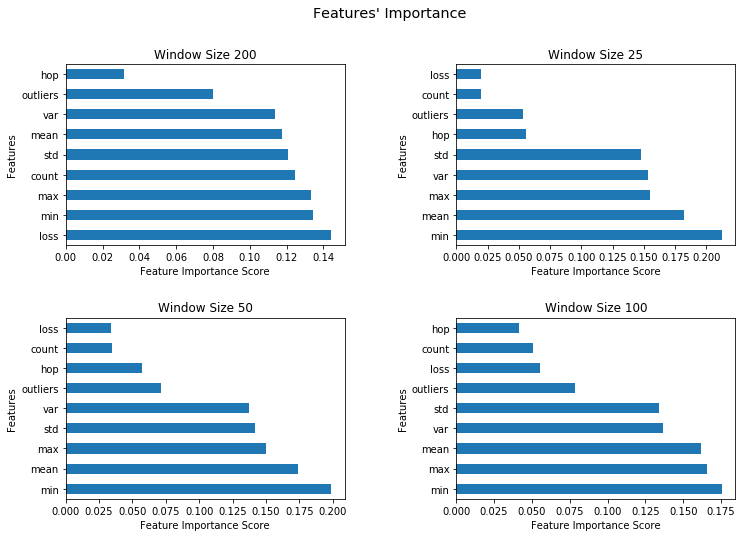

In [4]:
plots_analysis.random_forests_features_selection(trace_stats)

In [5]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [6]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [7]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [29]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [9]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

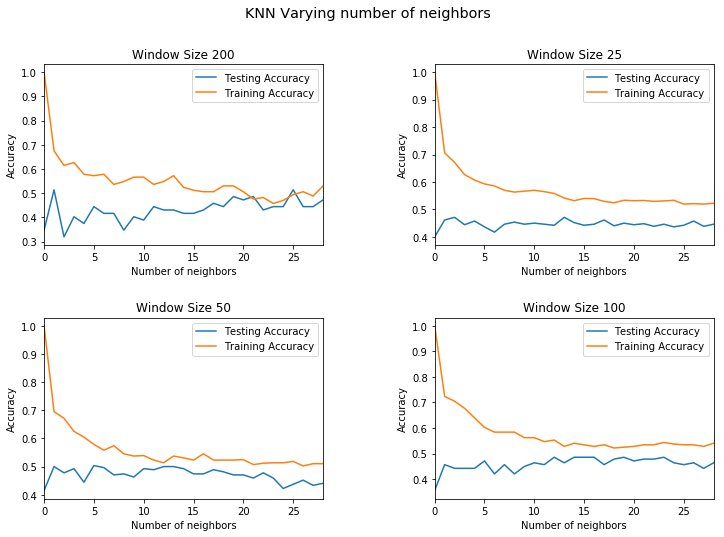

In [10]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [11]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=17)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [12]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=17)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [30]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [14]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [31]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [16]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [32]:
net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [18]:
'''
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])
'''

'\ncv_net_results = pd.concat([cv_net_results, \n                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)\n                    ])\n'

# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [33]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [34]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [35]:
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [36]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Per Node Results

Results for each model

In [23]:
results = results.rename(index=str, columns={"Training Time (ms)": "Training Time (sec)", "Testing Time (ms)": "Testing Time (sec)"})
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.375000,0.339683,0.304658,0.304515,0.117664,0.007008
1,Random Forest,25,0.457692,0.419100,0.404102,0.406480,0.235971,0.013765
2,Random Forest,50,0.485185,0.503960,0.412401,0.406245,0.131946,0.009276
3,Random Forest,100,0.492754,0.426704,0.422091,0.414512,0.093656,0.009655
4,KNN,200,0.430556,0.343798,0.341783,0.318001,0.001756,0.003776
5,KNN,25,0.448077,0.447867,0.363133,0.354187,0.001856,0.024350
6,KNN,50,0.474074,0.483189,0.382155,0.351495,0.001806,0.009169
7,KNN,100,0.492754,0.559524,0.401863,0.377787,0.001102,0.004879
8,SVM,200,0.388889,0.222222,0.294648,0.253276,0.003164,0.001382
9,SVM,25,0.465385,0.497582,0.341386,0.287207,0.106781,0.014111


Here we plot the average results for each model

In [24]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.410995
1,Random Forest,25,0.426855
2,Random Forest,50,0.431145
3,Random Forest,100,0.447727
4,KNN,200,0.381548
5,KNN,25,0.430900
6,KNN,50,0.426824
7,KNN,100,0.439169
8,SVM,200,0.406828
9,SVM,25,0.448851


# Network Results
Here we print the results from each model on the whole network

In [25]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.444444,0.500000,0.311111,0.348485,0.065386,0.006304
1,Random Forest,25,0.500000,0.166667,0.333333,0.222222,0.060443,0.006491
2,Random Forest,50,0.361111,0.139785,0.270833,0.184397,0.060023,0.006321
3,Random Forest,100,0.611111,0.436508,0.444444,0.409018,0.063069,0.010255
4,KNN,200,0.333333,0.555556,0.244444,0.333333,0.001331,0.003853
5,KNN,25,0.500000,0.166667,0.333333,0.222222,0.001759,0.006565
6,KNN,50,0.472222,0.485714,0.357143,0.253595,0.000894,0.001863
7,KNN,100,0.166667,0.100000,0.111111,0.105263,0.001371,0.002692
8,SVM,200,0.555556,0.476190,0.466667,0.390476,0.002394,0.001254
9,SVM,25,0.500000,0.166667,0.333333,0.222222,0.001489,0.000768


Here we plot the average results for each model computed with cross validation

In [26]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.533670
1,Random Forest,25,0.474791
2,Random Forest,50,0.491245
3,Random Forest,100,0.550042
4,KNN,200,0.436700
5,KNN,25,0.504170
6,KNN,50,0.500005
7,KNN,100,0.533375
8,OneVsRestClassifier (SVM),200,0.473064
9,OneVsRestClassifier (SVM),25,0.512661
